###**Made by Varun Kumar**
(as a part of Deakin University SIT744 Deep Learning)

---
# **Task 1**
### **1.1) Defining the Problem**
Waste contamination in recycling is increasingly prevalent due to unawareness of people about which items are recyclable and which are not. **[source](https://www.cleanup.org.au/recycle)**<br>
This results in entire batches of recyclables to be discarded and dumped. Thus, exacerbating the problem of pollution while wasting resources at the same time. <br>
This project aims to generate an Image Classifier that takes RGB images of waste materials as inputs and classifies them into 6 different classes (see dataset description below) using CrossEntropyLoss.

###**1.2) Dataset Description**
For this multi-class image classification task, I've decided to use Gary and Mindy's TrashNet dataset. [TrashNet](https://github.com/garythung/trashnet) [Research Paper Link](https://cs229.stanford.edu/proj2016/report/ThungYang-ClassificationOfTrashForRecyclabilityStatus-report.pdf)

TrashNet contains over 2500 images of different waste materials segregated into folders acting as their labels.<br>
It has 6 folders/labels namely:


*   Cardboard
*   Plastic
*   Metal
*   Glass
*   Paper
*   Trash

Since TrashNet already has images saved in separate folders based on their labels, we do not need to explicitly set labels on the images. <br>
Moreover, PyTorch's ImageFolder class can be used to handle such organised data.


###**Loading the Dataset from Google Drive**

####**Import all required libraries and set seed**

In [ ]:
#Import all necessary libraries
from google.colab import drive
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from copy import deepcopy
from tqdm import tqdm


# Mount Google Drive
drive.mount('/content/drive')

# Set global random seed for reproducibility
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Mounted at /content/drive


####**Load raw images**

In [ ]:
# Load images as raw PIL images
dataset = ImageFolder(root='/content/drive/MyDrive/SIT744_FOLDER/Data/TrashNet/trashnet', transform=None)
class_names = dataset.classes
targets = dataset.targets

####**Default transform**

In [ ]:
# Define a default transform to normalize images
default_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

####**Create another instance for viewing image statistics and samples before proceeding**


In [ ]:
#Create another instance for viewing image statistics and samples before proceeding
dataset_transformed = ImageFolder(root='/content/drive/MyDrive/SIT744_FOLDER/Data/TrashNet/trashnet', transform=default_transform)

### **Showing details of TrashNet (dataset**)

In [ ]:
# Check dataset size and class names
print(f"Total images: {len(dataset)}")
print(f"Class names: {class_names}")
print(f"Class Encoding: {dataset.class_to_idx}")

Total images: 2527
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class Encoding: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


### **Visualising Class Distribution**

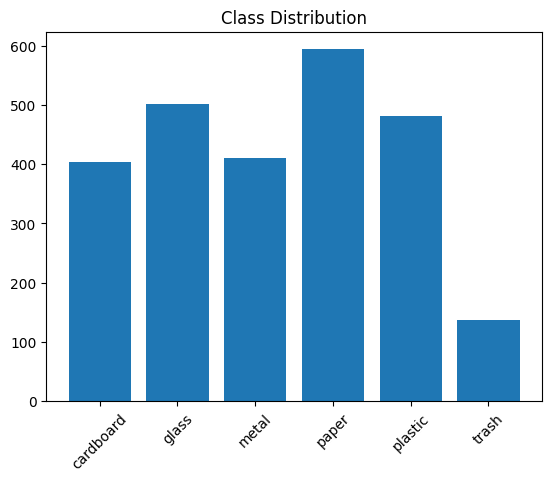

cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


In [ ]:
import matplotlib.pyplot as plt

class_counts = np.bincount(dataset.targets)

# Visualizing counts
plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Print class counts
for i, count in enumerate(class_counts):
    print(f"{dataset.classes[i]}: {count}")

As we can observe from the class distribution, all classes are fairly balanced except "trash" which is the minority class with only 137 samples.<br>
We will need to balance the training dataset (later) to ensure proper learning.

####**Shape of first image**

In [ ]:
# Check shape of first image tensor (using the normalised instance)
img, _ = dataset_transformed[0]
print(f"Image shape: {img.shape}")

Image shape: torch.Size([3, 224, 224])


### **Showing random sample images**

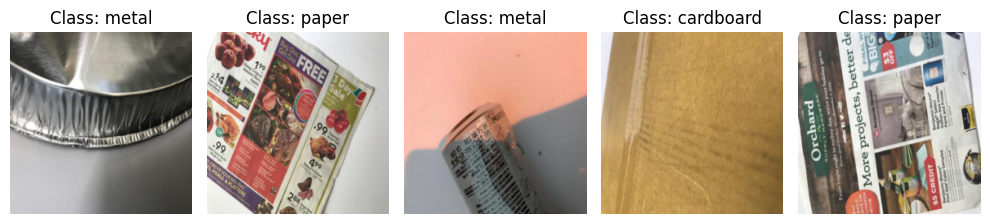

In [ ]:
import random

def show_random_samples(dataset, n=5):

    # Get random indices spanning the entire dataset
    random_indices = random.sample(range(len(dataset)), n)

    fig, axes = plt.subplots(1, n, figsize=(10, 3))
    if n == 1:
        axes = [axes]  # Ensure axes is iterable even for n=1

    for i, idx in enumerate(random_indices):
        img, label = dataset[idx]

        # Convert to numpy and de-normalize
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {dataset.classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

#Using normalised instance
show_random_samples(dataset_transformed, n=5)

### **Analysing Patterns in TrashNet**

####**1. Correlation Heatmap**
Note: Feature extraction via ResNet18 takes around 5 minutes on T4 GPU

In [ ]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights).to(device).eval()
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# DataLoader
dataloader = DataLoader(dataset_transformed, batch_size=128, shuffle=False, num_workers=2)

# Extract features
features, labels = [], []
with torch.no_grad():
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        outputs = feature_extractor(inputs).squeeze(-1).squeeze(-1)
        features.append(outputs.cpu())
        labels.append(targets)

features = torch.cat(features)
labels = torch.cat(labels)

# Compute class-wise averages
class_features = {}
for class_id in torch.unique(labels):
    class_mask = (labels == class_id)
    class_features[class_id.item()] = features[class_mask].mean(dim=0).numpy()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


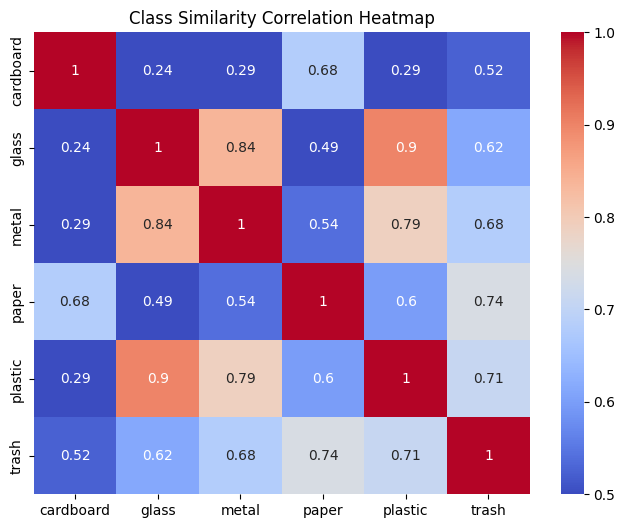

In [ ]:
import seaborn as sns
# Calculate correlation matrix
corr_matrix = np.corrcoef(list(class_features.values()))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    xticklabels=class_names,
    yticklabels=class_names,
    vmin=0.5,
    vmax=1.0
)
plt.title('Class Similarity Correlation Heatmap')
plt.show()

#### **Observations**
* Glass and Plastic share the strongest similarity based on the brightest intensity due to similar structural or surface properties.

* Metal and Glass exhibit noticeable resemblance, hinting at common visual traits such as sheen or transparency.

* Trash appears moderately blended with multiple categories, indicating it lacks strong visual alignment with any single material. Example: soft plastics which appear same as hard plastics or glass. Also, waste paper is well-linked with trash.


####**2. Clustering**


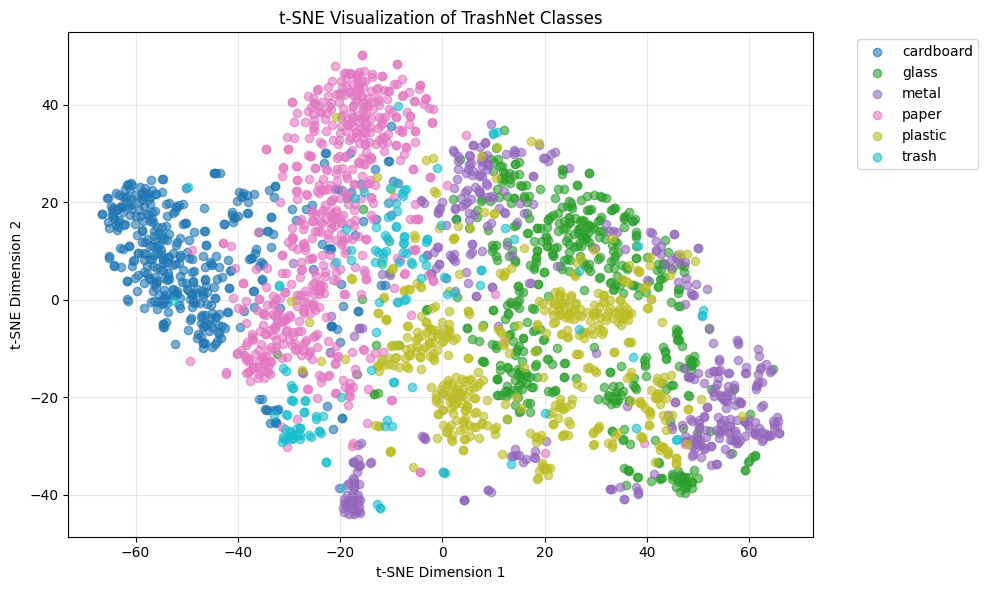

In [ ]:
from sklearn.manifold import TSNE

#Apply t-SNE to reduce dimensionality for plotting
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

# Plot Clusters
colors = plt.get_cmap('tab10', len(class_names))

plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_names):
    mask = (labels == i)
    plt.scatter(features_2d[mask, 0],
                features_2d[mask, 1],
                color=colors(i),
                label=class_name,
                alpha=0.6)

plt.title('t-SNE Visualization of TrashNet Classes')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

####**Observations**

* All materials have moderately-distinct clusters indicating some differentiating factor from others. For instance, plastic and cardboard are not well-linked since plastic has a shine while cardboard doesn't.

* Some material pairs are in close proximity to each other, like, Glass-Plastic, Metal-Plastic, Metal-Glass, Cardboard-Paper and Glass-Metal indicating strong visual similarities due to lusture, shine, transparency or roughness.

* Trash appears to be well dispersed and can be located as overlapping in almost all clusters but especially higher in cardboard and paper (since those are higher in trash items).

### **Splitting the dataset into Train-Val-Test splits**
In this, we will use the dataset with no transform. (raw)


=== Random Split ===
Class       	Train 	Val   	Test  
cardboard   	279   	61    	63    
glass       	349   	70    	82    
metal       	287   	65    	58    
paper       	417   	85    	92    
plastic     	347   	70    	65    
trash       	89    	28    	20    


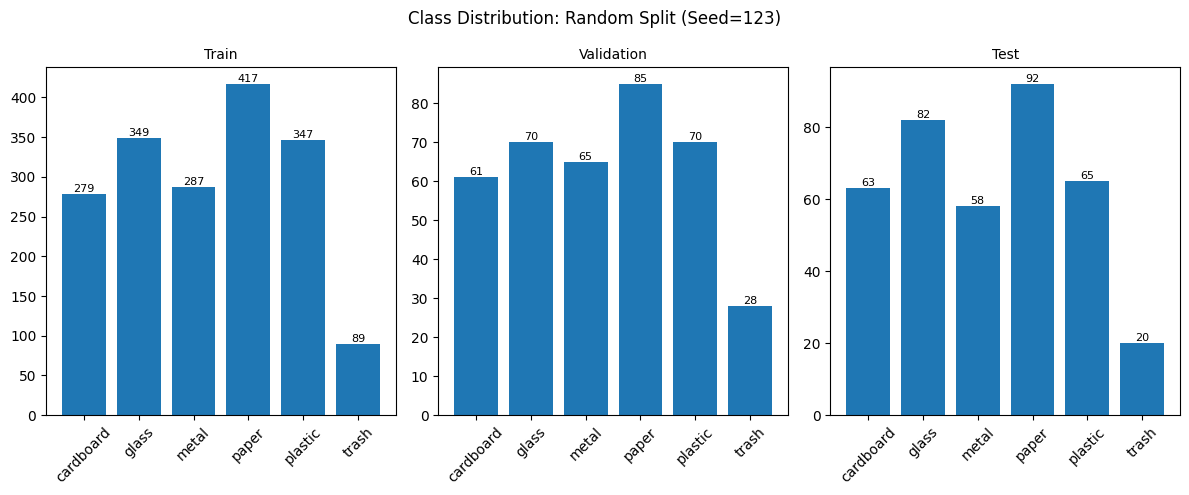


=== Stratified Split ===
Class       	Train 	Val   	Test  
cardboard   	282   	61    	60    
glass       	350   	75    	76    
metal       	287   	61    	62    
paper       	416   	89    	89    
plastic     	337   	72    	73    
trash       	96    	21    	20    


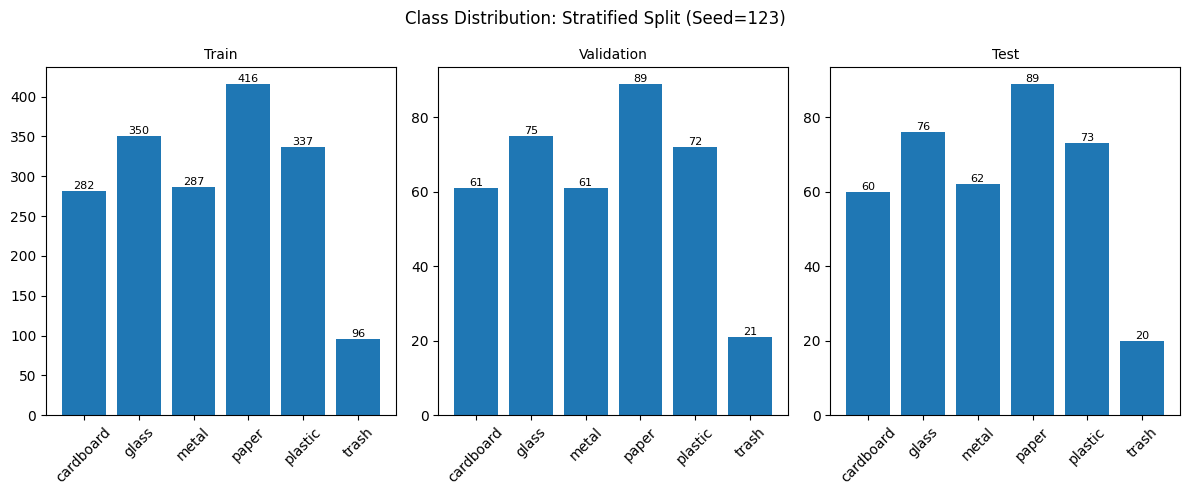

In [ ]:
from sklearn.model_selection import train_test_split

# Function to plot class distribution
def plot_distribution(subsets, titles, suptitle):
    plt.figure(figsize=(12, 5))
    for i, (subset, title) in enumerate(zip(subsets, titles), 1):
        plt.subplot(1, 3, i)
        counts = np.bincount([targets[i] for i in subset])
        plt.bar(class_names, counts)
        plt.title(title, fontsize=10)
        plt.xticks(rotation=45)
        for j, count in enumerate(counts):
            plt.text(j, count, str(count), ha='center', va='bottom', fontsize=8)
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# 1. Random Split
def random_split_dataset():
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    indices = np.arange(len(dataset))
    np.random.seed(SEED)
    np.random.shuffle(indices)

    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size+val_size]
    test_idx = indices[train_size+val_size:]

    return train_idx, val_idx, test_idx

# 2. Stratified Split
def stratified_split_dataset():
    #30% test size, 70% train size
    train_idx, temp_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.3,
        stratify=targets,
        random_state=SEED
    )
    #15% test size, 15% val size
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=targets[temp_idx],
        random_state=SEED
    )
    return train_idx, val_idx, test_idx

# Compare both methods
targets = np.array(dataset.targets)
for split_method, name in [(random_split_dataset, "Random Split"),
                         (stratified_split_dataset, "Stratified Split")]:
    train_idx, val_idx, test_idx = split_method()

    print(f"\n=== {name} ===")
    print(f"{'Class':<12}\t{'Train':<6}\t{'Val':<6}\t{'Test':<6}")
    for i, class_name in enumerate(class_names):
        train_count = np.sum(targets[train_idx] == i)
        val_count = np.sum(targets[val_idx] == i)
        test_count = np.sum(targets[test_idx] == i)
        print(f"{class_name:<12}\t{train_count:<6}\t{val_count:<6}\t{test_count:<6}")

    # Visualize
    plot_distribution(
      [train_idx, val_idx, test_idx],
      ['Train', 'Validation', 'Test'],
      f'Class Distribution: {name} (Seed={SEED})'
    )

####**Comparison of Random Split and Stratified Split at 70:15:15 ratio**
From the two plots, we conclude that both methods produce similar distributions (with minor differences). <br><br>
However, since stratified sampling always maintains the original ratio of class imbalance, we will pick this option as it maintains the dataset bias during splitting. <br><br>
Later, to fix the imbalance, we will balance the training dataset after splitting.<br><br>
This will ensure that during training, all the classes have similar distributions, while during inference the test and validation splits are untouched and have the original imbalance as it is, thus, mimicking a real world scenario.

### **Why 70:15:15 Train-Val-Test split?**
Well, since the dataset only contains about 2500 samples, a relatively large train set is required, so (say) 60% would be insufficient to learn significant patterns, while 80% or more could result in overfitting due to small dataset size (dataset bias).<br><br>
Also, to tune the hyper-parameters effectively, we need enough samples in the validation set. Therefore, 15% for validation is a good arbitrary ratio.<br><br>
Lastly, the test set has the remaining 15% samples to test the model's generalisation ability on unseen data.

###**Creating data loaders (regular)**

In [ ]:
#Since the last iteration for sampling was stratified, we don't need to repeat it
# train_idx, test_idx and val_idx will help us compute stratified splits

from torch.utils.data import Subset, DataLoader

# Create subset wrappers
train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

In [ ]:
# Wrap subsets so that a transform is applied when an item is fetched.
class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# Apply default transform for base train, val and test sets
#Note: val and test sets after this will be untouched
train_dataset = TransformedSubset(train_subset, default_transform)
val_dataset = TransformedSubset(val_subset, default_transform)
test_dataset = TransformedSubset(test_subset, default_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
#Function to count class distribution for each data loader
def print_split_stats(name, loader):
    #Extract labels from loader
    targets = np.concatenate([labels.numpy() for _, labels in loader])

    # Compute class counts
    class_counts = np.bincount(targets, minlength=len(class_names))

    # Print results
    print(f"\n{name} ({len(loader.dataset)} samples):")
    for class_name, count in zip(class_names, class_counts):
        print(f"- {class_name}: {count}")

In [ ]:
#Show status for each data loader (class distribution)
print_split_stats("Train", train_loader)
print_split_stats("Validation", val_loader)
print_split_stats("Test", test_loader)


Train (1768 samples):
- cardboard: 282
- glass: 350
- metal: 287
- paper: 416
- plastic: 337
- trash: 96

Validation (379 samples):
- cardboard: 61
- glass: 75
- metal: 61
- paper: 89
- plastic: 72
- trash: 21

Test (380 samples):
- cardboard: 60
- glass: 76
- metal: 62
- paper: 89
- plastic: 73
- trash: 20


### **Balancing the training dataset**
Since the training dataset has imbalances, we will now make it balanced through data augmentation.<br>
This will result in a balanced dataset where all classes are almost equal in representation and it will help optimise the model better.<br><br>
Train (1768 samples):
- cardboard: 282
- glass: 350
- metal: 287
- paper: 416
- plastic: 337
- trash: 96 (minority class)

####**Balancing data augmentation**

In [ ]:
# Define Data Augmentations
balancing_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Since the images for waste management are not dependent on orientation, we can apply transforms like "RandomHorizontalFlip".<br>
Also, other minor augmentations like RandomRotation, ColorJitter, RandomAffine are used to provide slight translations, change in color and minor rotation. <br>
Lastly, we resize the images to be same as the original dataset's images (224x224 pixels).

###**Balaced Dataset Class**
Finds the max class count and matches all other class counts to it by incorporating augmented images.

In [ ]:
from collections import Counter

class BalancedDataset(Dataset):
    def __init__(self, original_dataset, original_indices, transform=None):
        self.original_dataset = original_dataset
        self.original_indices = original_indices
        self.transform = transform

        # Extract labels from the dataset's samples (each sample is a tuple: (path, label))
        self.labels = [original_dataset.samples[i][1] for i in original_indices]
        self.class_counts = Counter(self.labels)
        self.max_count = max(self.class_counts.values())

        self.index_map = []

        # Adding both augmented (new) and non-augmented (original) samples
        for class_label in self.class_counts:
            # Get all indices from original_indices that belong to this class
            class_indices = [idx for idx in original_indices if original_dataset.samples[idx][1] == class_label]
            # Add original samples
            for idx in class_indices:
                self.index_map.append((idx, False))
            # Add extra samples via augmentation (oversampling + augmentation)
            num_needed = self.max_count - len(class_indices)
            for _ in range(num_needed):
                chosen_idx = np.random.choice(class_indices)
                self.index_map.append((chosen_idx, True))

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        original_idx, augment = self.index_map[idx]
        image, label = self.original_dataset[original_idx]
        if augment and self.transform is not None:
            image = self.transform(image)
        else:
            # For original images, apply default transform
            image = default_transform(image)
        return image, label

###**Balanced Train dataset instance and Train loader**

In [ ]:
# Create balanced training dataset instance
balanced_train_dataset = BalancedDataset(dataset, train_idx, transform=balancing_augment)

# Create balanced train loader
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=128, shuffle=True, num_workers=2)

###**Check distribution after balancing**

In [ ]:
#Verify balanced train loader composition
print_split_stats("Balanced Training set", balanced_train_loader)


Balanced Training set (2496 samples):
- cardboard: 416
- glass: 416
- metal: 416
- paper: 416
- plastic: 416
- trash: 416


###**Visualize Balanced Train Dataset samples**

In [ ]:
#Function to plot balanced train loader samples (augmented)
def plot_loader_samples(loader, class_names, n_samples=8):
    images, labels = next(iter(loader))

    plt.figure(figsize=(12, 5))
    for i in range(n_samples):
        plt.subplot(2, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        plt.imshow(img.clip(0, 1))
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

###**Visualize class distribution**

In [ ]:
# Plot distribution from a loader (class counts)
def show_loader_distribution(loader, name, class_names):
    counts = []
    for _, labels in loader:
        counts.extend(labels.numpy())
    counts = np.bincount(counts, minlength=len(class_names))
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, counts)
    plt.ylabel('Count')
    plt.title(f"{name} Training Set Distribution")
    plt.xticks(rotation=45)
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

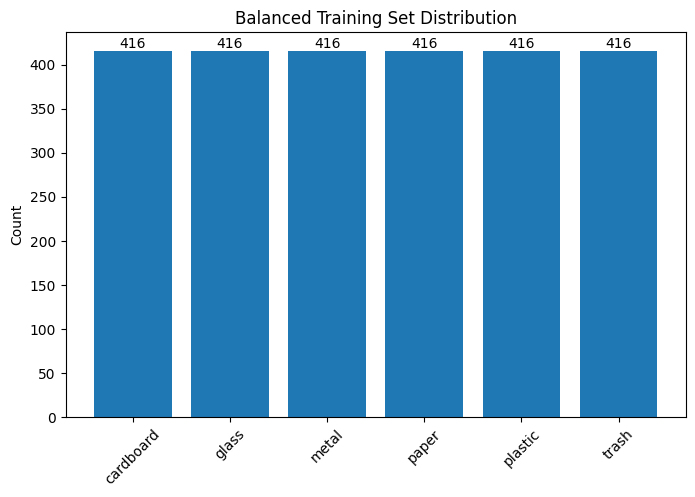

In [ ]:
#Print loader distribution
show_loader_distribution(balanced_train_loader, "Balanced", class_names)

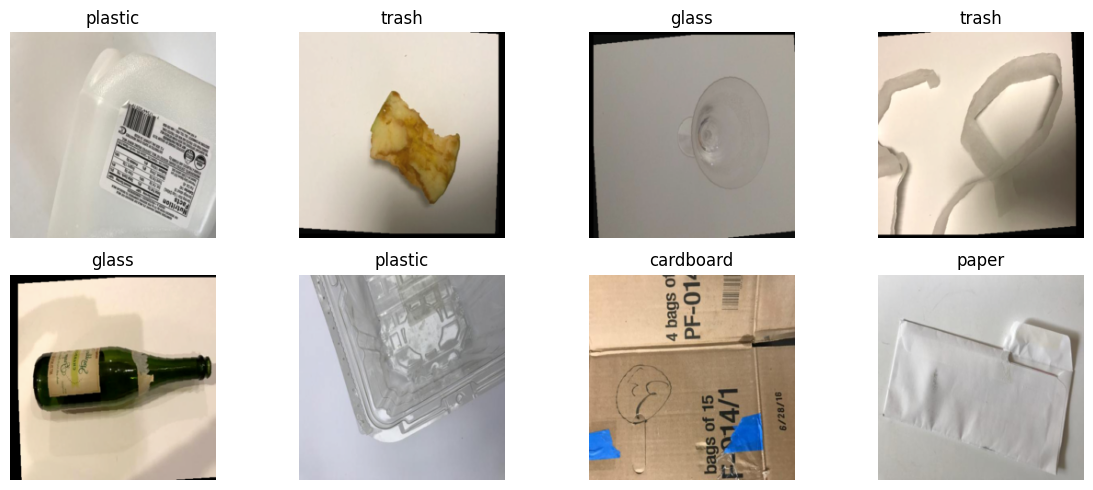

In [ ]:
#Show some augmented samples
plot_loader_samples(balanced_train_loader, class_names, 8)

###**Final Data Dimensions**


In [ ]:
#Final training dataset size
print(f"Final training dataset size (post balancing): {len(balanced_train_dataset)}")

#Final test dataset size
print(f"Final test dataset size: {len(test_dataset)}")

#Final validation dataset size
print(f"Final validation dataset size: {len(val_dataset)}")

Final training dataset size (post balancing): 2496
Final test dataset size: 380
Final validation dataset size: 379


To conclude pre-processing, we managed to balance the training dataset by introducing augmented samples from the training set itself.<br>
This helped us create a uniform distribution in the training set which will provide great optimisation ability to the ConvNet model.<br>


##**1.3 Deep Learning Model**

###**Transfer Learning (using ResNet50)**
Since learning patterns from images for a custom newbie CNN is difficult, I'm using the pretrained ResNet50 model for it is robust and will allow better generalisation for TrashNet dataset.

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class ResNet50WasteClassifier(nn.Module):
    def __init__(self, num_classes, freeze_features=False):
        super(ResNet50WasteClassifier, self).__init__()
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Optionally freeze convolutional weights
        if freeze_features:
            for param in self.base_model.parameters():
                param.requires_grad = False

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

###**Training and Evaluation**

####**Various model instances**

In [ ]:
num_classes = len(class_names)

# Model 1: Freeze all features (only the classifier is trained)
model1 = ResNet50WasteClassifier(num_classes, freeze_features=True)

# Model 2: Fine-tune the entire network (no freezing)
model2 = ResNet50WasteClassifier(num_classes, freeze_features=False)

# Model 3: Freeze most features but unfreeze the last convolutional block (layer4)
model3 = ResNet50WasteClassifier(num_classes, freeze_features=True)
for param in model3.base_model.layer4.parameters():
    param.requires_grad = True

# Model Variants
model_variants = {
    "Model 1": model1,
    "Model 2": model2,
    "Model 3": model3
}

####**Evaluate helper function**

In [ ]:
# Evaluation helper function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(loader), 100 * correct / total

####**Training Function**

In [ ]:
# Training function with early stopping based on validation accuracy
def train_model(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0
    patience_counter = 0

    print(f"\nTraining {model.__class__.__name__}")
    print(f"{'Epoch':<8}{'Train Loss':<15}{'Val Acc (%)':<15}")
    print("-" * 40)

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # Validation phase
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping triggered!")
                break

        print(f"{epoch+1:<8}{train_losses[-1]:<15.4f}{val_acc:<15.2f}")

    # Load best model weights for final evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "test_loss": [test_loss],
        "train_acc": train_accs,
        "val_acc": val_accs,
        "test_acc": [test_acc]
    }

####**Visualisation Function**

In [ ]:
#Function to plot metrics (loss and accuracy)
def plot_results(results):
    plt.figure(figsize=(15, 6))
    # Plot training loss
    plt.subplot(1, 2, 1)
    for name, res in results.items():
        plt.plot(res['train_loss'], label=name, linewidth=2)
    plt.title("Training Loss Comparison", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    for name, res in results.items():
        plt.plot(res['val_acc'], label=name, linewidth=2)
    plt.title("Validation Accuracy Comparison", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()


####**Function call for training and evaluation using normal data loader (no augmentation, no balancing)**
Note: this analysis takes 3min on T4 GPU


Training Model 1

Training ResNet50WasteClassifier
Epoch   Train Loss     Val Acc (%)    
----------------------------------------
1       1.5208         67.55          
2       0.8589         80.47          
3       0.6727         80.47          
4       0.5751         81.00          
5       0.5136         81.79          
6       0.4764         82.85          
7       0.4327         86.81          
8       0.4505         84.70          
9       0.3868         84.43          

Early stopping triggered!

Final Test Accuracy: 83.95%

Training Model 2

Training ResNet50WasteClassifier
Epoch   Train Loss     Val Acc (%)    
----------------------------------------
1       1.0742         50.92          
2       0.5694         73.35          
3       0.4055         79.16          
4       0.3340         75.73          
5       0.2760         77.57          

Early stopping triggered!

Final Test Accuracy: 75.26%

Training Model 3

Training ResNet50WasteClassifier
Epoch   Train Loss     Val

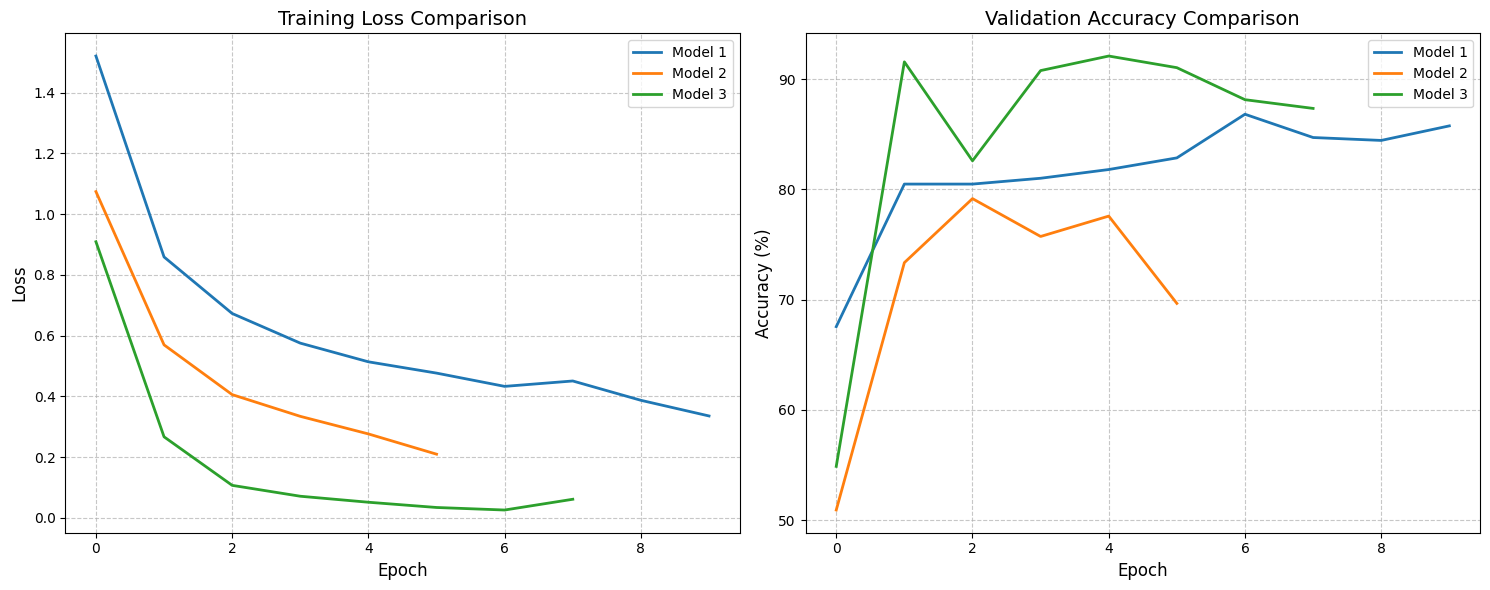

In [ ]:
from copy import deepcopy

results = {}
for name, model in model_variants.items():
    print(f"\nTraining {name}")
    results[name] = train_model(deepcopy(model), train_loader, val_loader, test_loader, epochs=20, patience=3)

# Visualize results
plot_results(results)

###**Observations**

| Model Variant | Final Test Accuracy |
|---------------|---------------------|
| Model 1       | 83.95%              |
| Model 2       | 75.26%              |
| Model 3       | 91.05%              |

###**Inference on Model Architecture Decisions**
1. ResNet50 Backbone: ResNet50 is pre-trained on ImageNet, so it already knows general image features. Its deep residual connections help it learn robust representations.

1. Model 1 (Fully Frozen): Only training the classifier leverages ResNet50’s learned features, offering decent performance. However, it can't adapt the high-level features to TrashNet, which caps its accuracy at around 84%.

2. Model 2 (Full Fine-Tuning): Fine-tuning every layer allows complete adaptation but risks overfitting on a smaller dataset like TrashNet. This is reflected in its lower accuracy (75%).

3. Model 3 (Selective Fine-Tuning): By unfreezing just the last convolutional block (layer4), Model 3 refines the most task-specific features while preserving earlier robust representations. This strikes the best balance, achieving 91% test accuracy.

This shows that adapting only the top layers of a pre-trained ResNet50 to the TrashNet domain yields superior performance with less risk of overfitting.

####**Final Model for Task1.3 is model3**

###**Task 2<br>Augmentation Pipeline**
In this section, I will be using the balanced dataset (created in above sections) and will apply different data augmentations and see which one performs the best using the best model from the previous step.

####**Define augmentations**

In [ ]:
import torchvision.transforms as transforms

augmentations = {
    'Aug1': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=5, shear=10, translate=(0.05, 0.05)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Aug2': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.7, 1.0)),
        transforms.RandomRotation(8),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.4, scale=(0.02, 0.2)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Aug3': transforms.Compose([
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.RandomInvert(p=0.15),
        transforms.RandomPosterize(bits=4, p=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(7),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

###**Regular Augmented Dataset class**
This applies augmentation to all images but doesn't balanced the dataset

In [ ]:
class RegularAugmentedDataset(Dataset):
    def __init__(self, original_dataset, original_indices, transform=None):
        self.original_dataset = original_dataset
        self.original_indices = original_indices
        self.transform = transform

    def __len__(self):
        return len(self.original_indices)

    def __getitem__(self, idx):
        original_idx = self.original_indices[idx]
        image, label = self.original_dataset[original_idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

####**Augmented Datasets (regular and balanced)**


In [ ]:
# Create augmented dataset instances for both regular and balanced versions
augmented_regular_datasets = {
    f"{name}_regular": RegularAugmentedDataset(dataset, train_idx, transform=augmentations[name])
    for name in augmentations
}
augmented_balanced_datasets = {
    f"{name}_balanced": BalancedDataset(dataset, train_idx, transform=augmentations[name])
    for name in augmentations
}
# Combine all augmentation experiments into one dictionary
augmented_datasets = {**augmented_regular_datasets, **augmented_balanced_datasets}
augmented_datasets

{'Aug1_regular': <__main__.RegularAugmentedDataset at 0x7f49a96bf1d0>,
 'Aug2_regular': <__main__.RegularAugmentedDataset at 0x7f49a96bee10>,
 'Aug3_regular': <__main__.RegularAugmentedDataset at 0x7f49a96bf710>,
 'Aug1_balanced': <__main__.BalancedDataset at 0x7f49a96be0d0>,
 'Aug2_balanced': <__main__.BalancedDataset at 0x7f49a969b910>,
 'Aug3_balanced': <__main__.BalancedDataset at 0x7f49a976b210>}

####**Augmented Dataloaders**

In [ ]:
#Creating augmented dataloaders for each augmented dataset instance
augmented_dataloaders = {f"{name}_loader": DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2) for name, dataset in augmented_datasets.items()}
augmented_dataloaders

{'Aug1_regular_loader': <torch.utils.data.dataloader.DataLoader at 0x7f49a96bfb10>,
 'Aug2_regular_loader': <torch.utils.data.dataloader.DataLoader at 0x7f49a96430d0>,
 'Aug3_regular_loader': <torch.utils.data.dataloader.DataLoader at 0x7f49a96b7f50>,
 'Aug1_balanced_loader': <torch.utils.data.dataloader.DataLoader at 0x7f49a47aa3d0>,
 'Aug2_balanced_loader': <torch.utils.data.dataloader.DataLoader at 0x7f49a47a9f10>,
 'Aug3_balanced_loader': <torch.utils.data.dataloader.DataLoader at 0x7f49a47aa890>}


Augmented Loader: Aug1_regular_loader


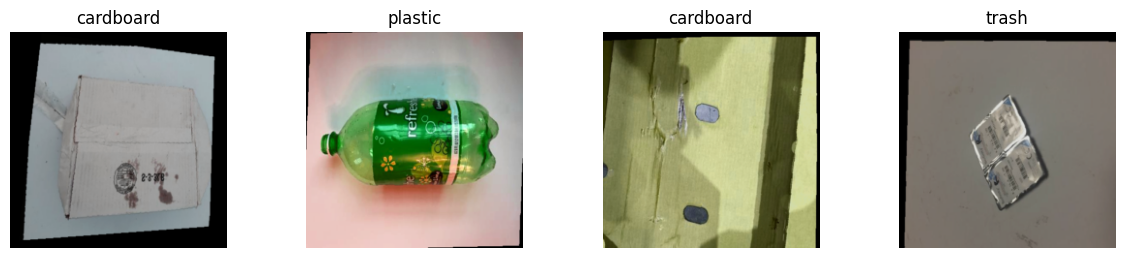


Augmented Loader: Aug2_regular_loader


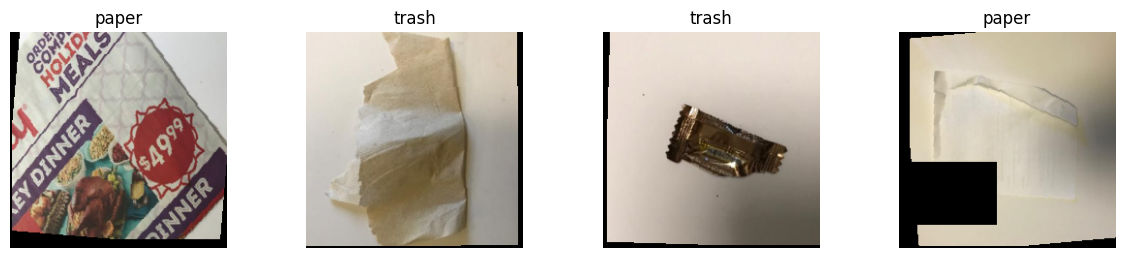


Augmented Loader: Aug3_regular_loader


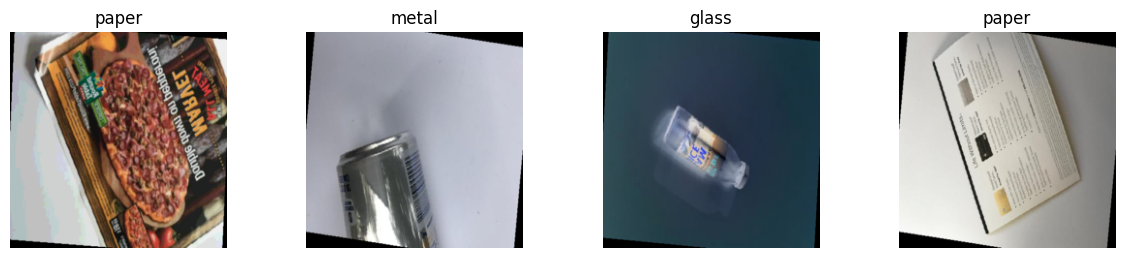


Augmented Loader: Aug1_balanced_loader


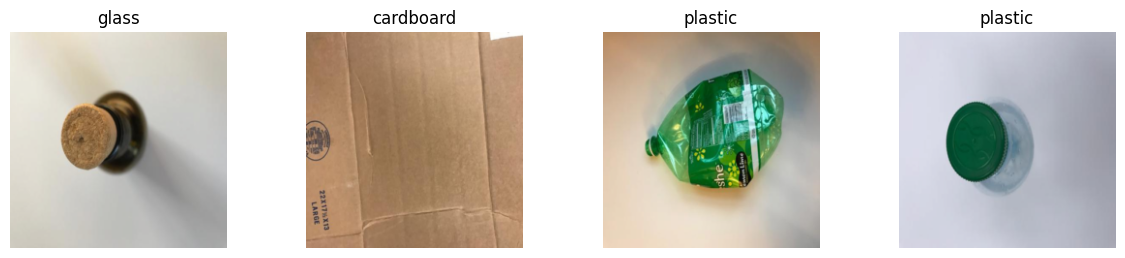


Augmented Loader: Aug2_balanced_loader


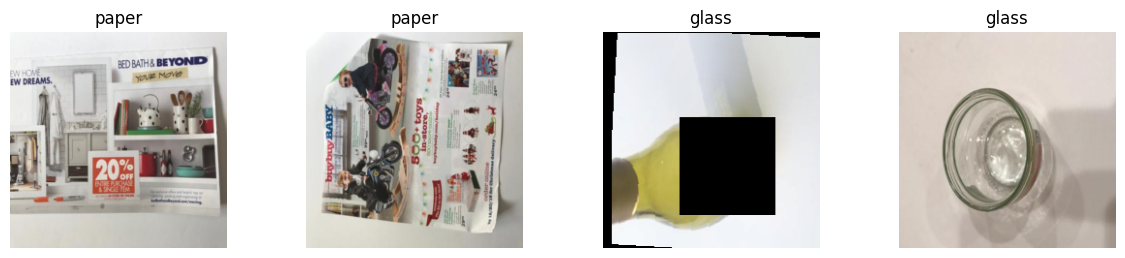


Augmented Loader: Aug3_balanced_loader


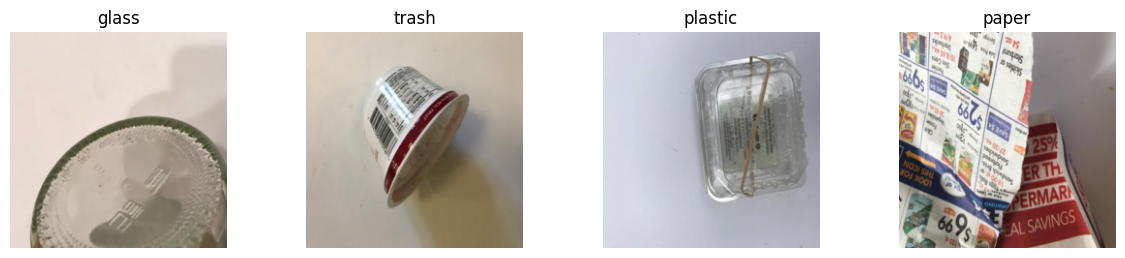

In [ ]:
# Show sample augmented images for each loader
for name, loader in augmented_dataloaders.items():
    print(f"\nAugmented Loader: {name}")
    plot_loader_samples(loader, class_names, n_samples=4)

###**Training with augmented dataloaders**
Note: Takes 10min on T4 GPU


Training best model with Aug1_regular_loader

Training ResNet50WasteClassifier
Epoch   Train Loss     Val Acc (%)    
----------------------------------------
1       0.9702         75.73          
2       0.4922         84.70          
3       0.3387         86.81          
4       0.2691         87.07          
5       0.1984         88.65          
6       0.1398         88.13          
7       0.1441         85.22          

Early stopping triggered!

Final Test Accuracy: 87.63%

Training best model with Aug2_regular_loader

Training ResNet50WasteClassifier
Epoch   Train Loss     Val Acc (%)    
----------------------------------------
1       1.0490         74.67          
2       0.4584         81.79          
3       0.2549         84.70          
4       0.1933         87.60          
5       0.1711         90.50          
6       0.1446         90.77          
7       0.1517         91.56          
8       0.1612         88.92          
9       0.1074         89.97          


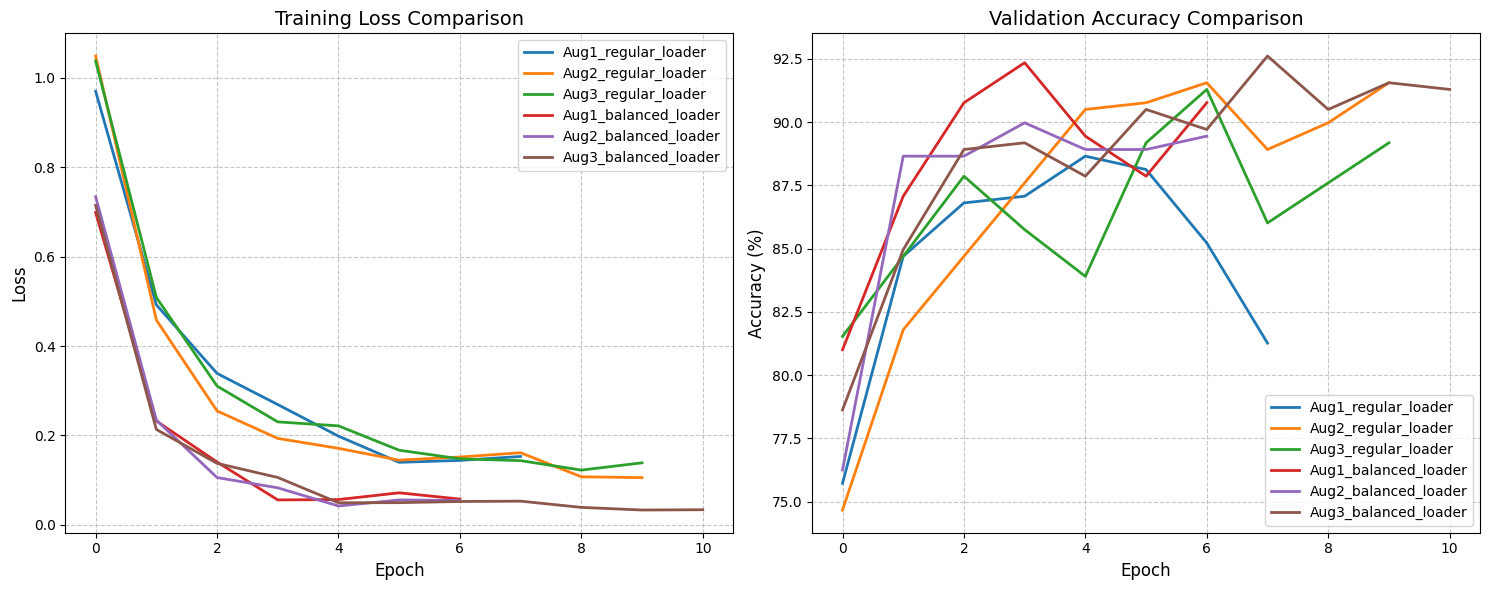

In [ ]:
# Train models on each augmented training loader using the best-model configuration.
#Create new instance
best_model = ResNet50WasteClassifier(num_classes, freeze_features=True)
for param in best_model.base_model.layer4.parameters():
    param.requires_grad = True

results = {}
for name, loader in augmented_dataloaders.items():
    print(f"\nTraining best model with {name}")
    model_instance = deepcopy(best_model)
    results[name] = train_model(model_instance, loader, val_loader, test_loader, epochs=20)

#Plot results
plot_results(results)

###**Comparison between augmentations**

| Loader Type            | Final Test Accuracy |
|------------------------|---------------------|
| Aug1_regular_loader    | 87.63%              |
| Aug2_regular_loader    | 90.26%              |
| Aug3_regular_loader    | 90.26%              |
| Aug1_balanced_loader   | 89.74%              |
| **Aug2_balanced_loader**   | **92.11%**              |
| Aug3_balanced_loader   | 90.00%              |


###**Conclusion**
1. Regular Loaders: When every image is augmented, the more aggressive distortions (as in Aug2 and Aug3) seem to help, both reaching about 90.26% accuracy. In contrast, the simpler Aug1 setup only got 87.63%, suggesting that moderate-to-strong spatial and erasing transforms can better challenge the model when no oversampling is applied.

2. Balanced Loaders: Oversampling to match the max class count improves class balance. Notably, Aug2_balanced_loader tops the chart at 92.11%, demonstrating that aggressive augmentations combined with oversampling not only balance the classes but also provide diverse, challenging examples that boost overall performance. Aug1 and Aug3 with balanced loaders, while still effective, didn’t reach the same peak, highlighting the importance of finding the right strength of augmentation in an oversampling context.

Overall, for TrashNet, using oversampling with moderately aggressive augmentations (like Aug2) yields the best results, while in the regular setting, stronger augmentations appear to compensate for the lack of class-balancing.

####1. Train Loss Convergence: The models trained with augmentation and balanced data showed a steady and smooth decline in loss, meaning they learned more effectively. The basic model took longer to reduce loss, indicating it wasn’t extracting features as efficiently at the start.

####2. Validation Accuracy Trend: The balanced models progressed more consistently with minimal fluctuations, while the basic model had some instability. Overfitting was largely avoided in the augmented models, but the basic setup showed signs of it as validation accuracy stalled later in training.

####3. Test Accuracy: The model trained with both augmentation and balanced sampling performed the best overall, reaching the highest accuracy. The basic model still achieved decent results, but the improvements in data preparation clearly helped in refining generalization.


###**Performance Gain**

| Loader Type               | Final Test Accuracy       |
|---------------------------|---------------------------|
| Aug2_balanced_loader      | 92.11% (balanced and augmented) |
| Basic train loader (y)    | 91.05% (no balancing or augmentation) |

###**Inference**
The results show that applying both balancing and augmentation (Aug2_balanced_loader) increases the final test accuracy by about 1% compared to the basic train loader.
Although this is just a 1% increase but since the test accuracy on resnet50 model was already astonishingly high at 91%, a further increase is commendable.<br>
This suggests that addressing class imbalance—combined with the right level of aggressive augmentations—helps the model learn more robustly, particularly by providing diverse examples from minority classes that improve generalization. Even a modest gain like this is valuable.

###**Profiling**
In this section, I've used torch.Profiler to wrap the data augmentation pipeline (augmented dataloader) and fed it the best-model and the best performing dataloader. <br>
This will help in pointing out which operation takes the longest time.

In [ ]:
import torch.profiler

best_loader = augmented_dataloaders['Aug2_balanced_loader']

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    record_shapes=True
) as profiler:
    for epoch in range(10):
        for data, labels in best_loader:
            profiler.step()

# Print the profiling summary to the console
print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        97.33%     710.092ms        97.34%     710.169ms     236.723ms             3  
                                          ProfilerStep*         2.65%      19.367ms       100.00%     729.537ms     243.179ms             3  
                                             aten::set_         0.01%      40.234us         0.01%      40.234us       6.706us             6  
                                            aten::empty         0.01%      37.337us         0.01%      37.337us       6.223us             6  
      

####From the logs, we conclude that "Dataloader" iteration is the bottleneck and consumes the most processing time. <br>In order to reduce this, we can increase "num_workers" and enabling "pin_memory" in the Dataloader constructor to speed things up.

In [ ]:
#Creating new and improved dataloader
new_dataset = BalancedDataset(dataset, train_idx, transform=augmentations['Aug2'])
new_loader = DataLoader(new_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

###**Check profile logs now**

In [ ]:
#After improvements
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    record_shapes=True
) as profiler:
    for epoch in range(10):
        for data, labels in new_loader:
            profiler.step()

# Print the profiling summary to the console
print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        99.64%      72.463ms        99.65%      72.475ms      24.158ms             3  
                                          ProfilerStep*         0.30%     219.908us        99.95%      72.695ms      24.232ms             3  
                                  cudaDeviceSynchronize         0.05%      32.839us         0.05%      32.839us      32.839us             1  
                               cudaPointerGetAttributes         0.02%      12.199us         0.02%      12.199us       6.099us             2  
------

###Improvements: After pin_memory is used (GPU) and num_workers to 4, the CPU total time came down to 72ms from 730ms!

###**Train and compare augmented and non-augmented for same training time**

In [ ]:
# Helper train function
def train_for_duration(model, train_loader, val_loader, test_loader, target_time, optimizer, criterion, device):
    start_time = time.time()
    epoch = 0
    best_val_acc = 0.0
    best_model_path = "temp_best_model.pth"

    while True:
        epoch += 1
        model.train()
        epoch_train_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validate at the end of the epoch
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch:>2} | Time: {elapsed_time:>5.2f} sec | "
              f"Train Loss: {avg_train_loss:>5.4f} | Train Acc: {train_acc:>5.2f}% | "
              f"Val Loss: {val_loss:>5.4f} | Val Acc: {val_acc:>5.2f}%")

        # Save the model if validation accuracy improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        # Stop training if target training time is exceeded
        if elapsed_time >= target_time:
            break

    # Load the best model and evaluate on the test set
    model.load_state_dict(torch.load(best_model_path))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc

In [ ]:
#Function to compare performance for same time
import time
import copy

# Main function to compare training pipelines for augmented and non-augmented dataloaders
def compare_training_pipelines(model, train_loader_aug, train_loader_non_aug, val_loader, test_loader, target_training_time, lr=0.001):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create deep copies of the original model for fair comparison
    model_aug = copy.deepcopy(model).to(device)
    model_non_aug = copy.deepcopy(model).to(device)

    # Define optimizers and loss function for both runs
    optimizer_aug = optim.Adam(model_aug.parameters(), lr=lr)
    optimizer_non_aug = optim.Adam(model_non_aug.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print("=== Training with Augmented DataLoader ===")
    test_loss_aug, test_acc_aug = train_for_duration(
        model_aug, train_loader_aug, val_loader, test_loader,
        target_training_time, optimizer_aug, criterion, device
    )

    print("=== Training with Non-Augmented DataLoader ===")
    test_loss_non_aug, test_acc_non_aug = train_for_duration(
        model_non_aug, train_loader_non_aug, val_loader, test_loader,
        target_training_time, optimizer_non_aug, criterion, device
    )

    metrics = {
        "augmented": {
            "test_loss": test_loss_aug,
            "test_acc": test_acc_aug
        },
        "non_augmented": {
            "test_loss": test_loss_non_aug,
            "test_acc": test_acc_non_aug
        }
    }
    return metrics

In [ ]:
#Comparison data loaders (augmented and non-augmented)
aug_loader = new_loader
base_loader = train_loader

In [ ]:
#Create new instance
best_model = ResNet50WasteClassifier(num_classes, freeze_features=True)
for param in best_model.base_model.layer4.parameters():
    param.requires_grad = True

In [ ]:
#Call comparison function trained for 60secs
metrics = compare_training_pipelines(best_model, aug_loader, base_loader, val_loader, test_loader, target_training_time=60)
metrics

=== Training with Augmented DataLoader ===
Epoch  1 | Time:  7.44 sec | Train Loss: 0.7077 | Train Acc: 73.52% | Val Loss: 4.0078 | Val Acc: 75.46%
Epoch  2 | Time: 15.33 sec | Train Loss: 0.1967 | Train Acc: 93.95% | Val Loss: 0.4928 | Val Acc: 90.24%
Epoch  3 | Time: 23.04 sec | Train Loss: 0.0968 | Train Acc: 96.88% | Val Loss: 0.4041 | Val Acc: 89.97%
Epoch  4 | Time: 30.34 sec | Train Loss: 0.0963 | Train Acc: 96.96% | Val Loss: 0.5587 | Val Acc: 88.65%
Epoch  5 | Time: 37.87 sec | Train Loss: 0.0642 | Train Acc: 98.12% | Val Loss: 0.3613 | Val Acc: 89.97%
Epoch  6 | Time: 45.35 sec | Train Loss: 0.0489 | Train Acc: 98.36% | Val Loss: 0.4402 | Val Acc: 89.18%
Epoch  7 | Time: 52.81 sec | Train Loss: 0.0540 | Train Acc: 98.32% | Val Loss: 0.3697 | Val Acc: 91.03%
Epoch  8 | Time: 60.65 sec | Train Loss: 0.0394 | Train Acc: 98.72% | Val Loss: 0.4539 | Val Acc: 90.77%

Final Test Loss: 0.3610 | Final Test Accuracy: 90.79%

=== Training with Non-Augmented DataLoader ===
Epoch  1 | Tim

{'augmented': {'test_loss': 0.3610144754250844, 'test_acc': 90.78947368421052},
 'non_augmented': {'test_loss': 0.4709853728612264,
  'test_acc': 90.52631578947368}}

Conclusion: As we can see, the augmented dataloader when fed to the resnet50 model was able to produce better test accuracy (generalisation).

###**Strengths and Weaknesses**
Incorrectly classified images

In [ ]:
#Get best model from path
best_model = ResNet50WasteClassifier(num_classes, freeze_features=True)
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
#Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

In [ ]:
#Function to obtain misclassified images
def evaluate_and_capture_errors(model, loader, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    misclassified = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch[:2]

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified.append({
                        "image": inputs[i].cpu(),
                        "gt": labels[i].cpu().item(),
                        "pred": predicted[i].cpu().item()
                    })

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy, misclassified

test_loss, test_acc, misclassified = evaluate_and_capture_errors(best_model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.4204
Test Accuracy: 90.00%


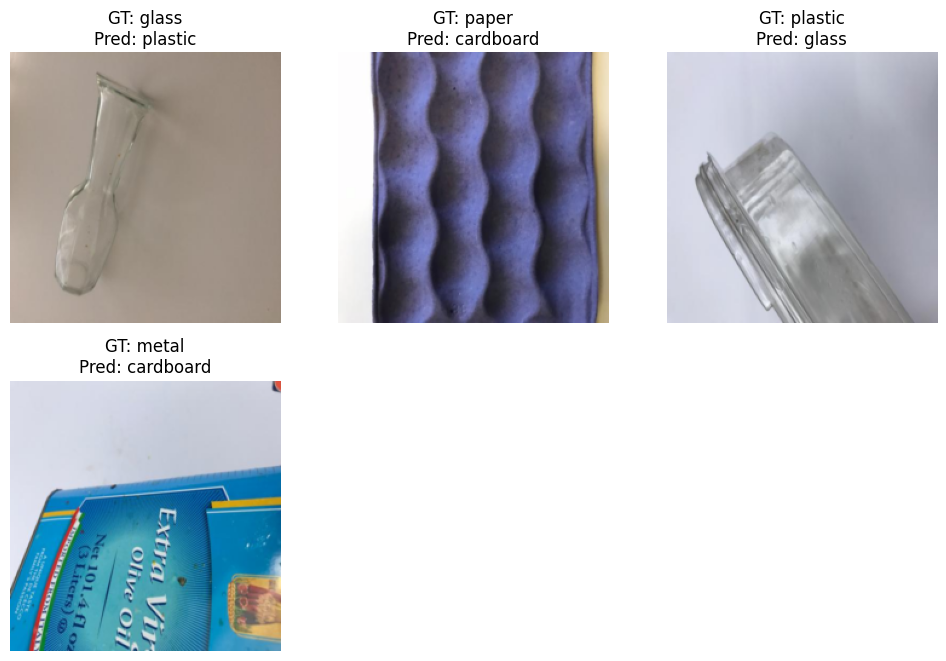

In [ ]:
import torchvision.transforms.functional as F

#Function to plot misclassified images (predicted vs ground truth/original labels)
def visualize_errors(misclassified, class_names, num_samples=9,
                     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(misclassified))):
        sample = misclassified[i]
        img_tensor = sample["image"].clone()
        # Denormalize inside the visualize function
        for t, m, s in zip(img_tensor, mean, std):
            t.mul_(s).add_(m)
        # Convert to a PIL image for display
        img = F.to_pil_image(img_tensor)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"GT: {class_names[sample['gt']]}\nPred: {class_names[sample['pred']]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

#Visualize the first 4 misclassified samples.
visualize_errors(misclassified, class_names, num_samples=4)

####Recall from earlier during correlation heatmap and tSNE clustering, we observed that some material pairs were closely related with very high correlations: Paper-Cardboard, Metal-glass, glass-plastic. <br>And as expected, the results show that most of the misclassifications were due to close resemblance of these material pairs.

###**Improve Generalisation across domains**
We will load new dataset for waste classification's test set.

In [ ]:
#New test dataset
new_test = ImageFolder(root='/content/drive/MyDrive/SIT744_FOLDER/Data/TrashNet/trashier_net', transform=default_transform)
new_test_targets = np.array(new_test.targets)

#New test set derived from kaggle/trashnet related dataset,
#https://www.kaggle.com/code/alistairking/recyclable-and-household-waste-classification-code/input and random image downloads

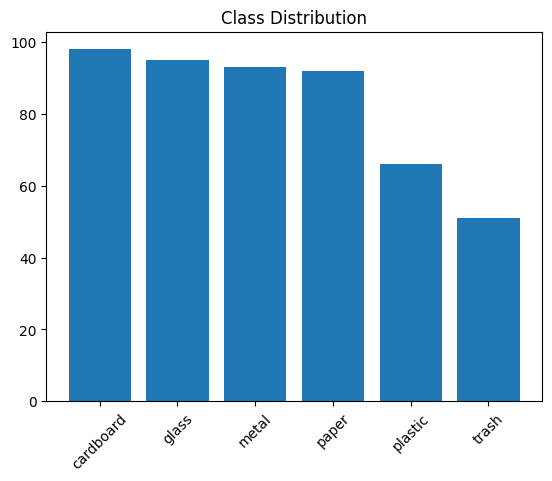

cardboard: 98
glass: 95
metal: 93
paper: 92
plastic: 66
trash: 51


In [ ]:
#Show new_test_set distribution

class_counts = np.bincount(new_test.targets)

# Visualizing counts
plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Print class counts
for i, count in enumerate(class_counts):
    print(f"{new_test.classes[i]}: {count}")

Original test data samples


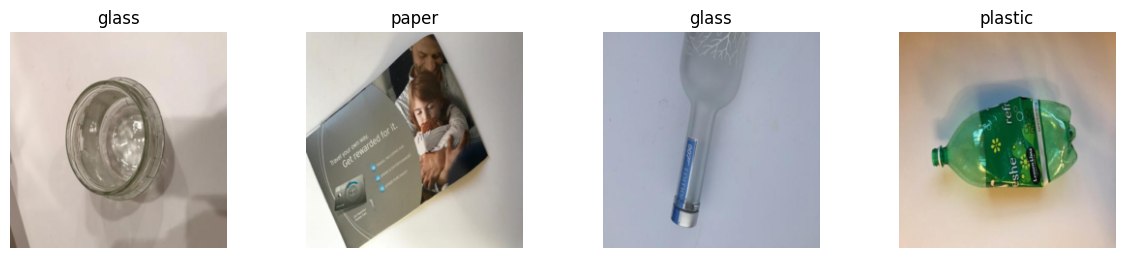

In [ ]:
#Random original test samples
print("Original test data samples")
plot_loader_samples(val_loader, class_names, 4)

New test data samples


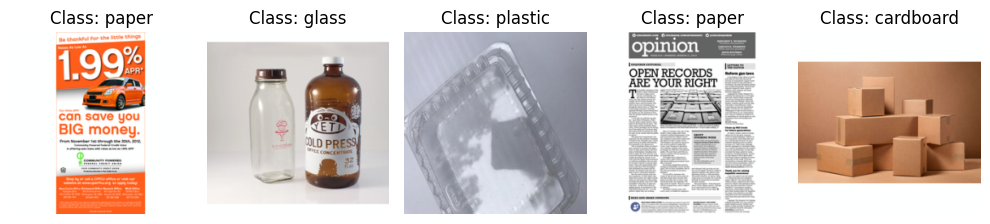

In [ ]:
#Random new test samples
print("New test data samples")
show_random_samples(new_test,5)

In [ ]:
#New test loader
new_test_loader = DataLoader(new_test, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
#Evaluate on new test set
test_loss, test_acc = evaluate(best_model, new_test_loader, nn.CrossEntropyLoss(), device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.8190
Test Accuracy: 81.82%


Through robust training, we trained an excellent classifier that can generalise new-unseen data at a 81% accuracy!

END OF DOCUMENT
---

---